In [ ]:
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import cv2
import random
from sklearn.model_selection import train_test_split
import torch.nn.utils.prune as prune
import json
import zipfile
from google.colab import drive

drive.mount('/content/drive')

with zipfile.ZipFile("/content/drive/MyDrive/Yeni WinRAR ZIP arşivi2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/ana_klasor")

Mounted at /content/drive


hemen bir ara bölüm: burada confusin matrixlerimi düzeltiyorum

In [ ]:
# Times New Roman'ı indir ve matplotlib'e ekle
!apt-get install -y fonts-texgyre
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# Matplotlib'e özel olarak tanımlama
plt.rcParams['font.family'] = 'Times New Roman'
# Eğer fontu bulamazsa fallback
if not any('Times New Roman' in f.name for f in fm.fontManager.ttflist):
    plt.rcParams['font.family'] = 'TeX Gyre Termes'


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-texgyre
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.2 MB of archives.
After this operation, 21.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-texgyre all 20180621-3.1 [10.2 MB]
Fetched 10.2 MB in 3s (3,863 kB/s)
Selecting previously unselected package fonts-texgyre.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../fonts-texgyre_20180621-3.1_all.deb ...
Unpacking fonts-texgyre (20180621-3.1) ...
Setting up fonts-texgyre (20180621-3.1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cihaz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validasyon datasetinin yolu
val_dir  = "/content/ana_klasor/without_augmentation"
img_size = 224
batch_size = 32

# Dönüşümler
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
class_names = val_dataset.classes
num_classes = len(class_names)

In [ ]:
def load_model(model_name, num_classes, weights_path):
    # Modeli çıktısı 1000 sınıf olarak oluştur
    model = timm.create_model(model_name, pretrained=False)
    state_dict = torch.load(weights_path, map_location=device)
    # Uyumlu katmanları yükle
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print(f"Missing keys: {missing}")         # Kontrol amaçlı
    print(f"Unexpected keys: {unexpected}")   # Kontrol amaçlı
    # Son katmanı değiştir
    if hasattr(model, "fc"):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, "head"):  # Timm modellerinde genelde 'head'
        if isinstance(model.head, nn.Linear):
            in_features = model.head.in_features
            model.head = nn.Linear(in_features, num_classes)
        elif isinstance(model.head, nn.Sequential):
            for i in range(len(model.head)):
                if isinstance(model.head[i], nn.Linear):
                    in_features = model.head[i].in_features
                    model.head[i] = nn.Linear(in_features, num_classes)
    model = model.to(device)
    model.eval()
    return model

def get_preds_and_labels(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={"fontsize":12, "fontweight":"bold"})
    ax.set_xlabel('Tahmin Edilen Sınıf', fontsize=14, color='black', fontweight='bold')
    ax.set_ylabel('Gerçek Sınıf', fontsize=14, color='black', fontweight='bold')
    ax.set_title(title, fontsize=16, color='black', fontweight='bold')
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')
    # Kenarlık ve grid ayarları
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    plt.show()

Missing keys: []
Unexpected keys: ['head.2.weight', 'head.2.bias']


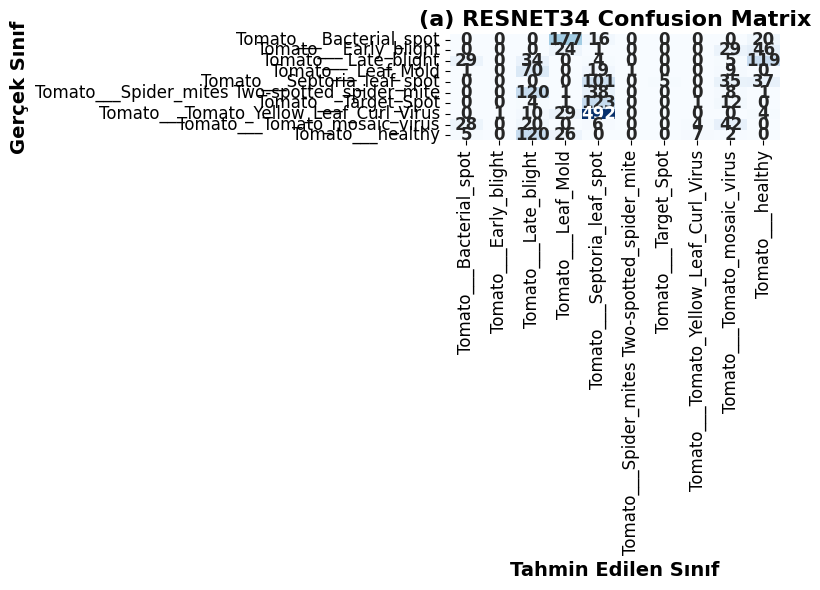

Missing keys: []
Unexpected keys: ['head.2.weight', 'head.2.bias']


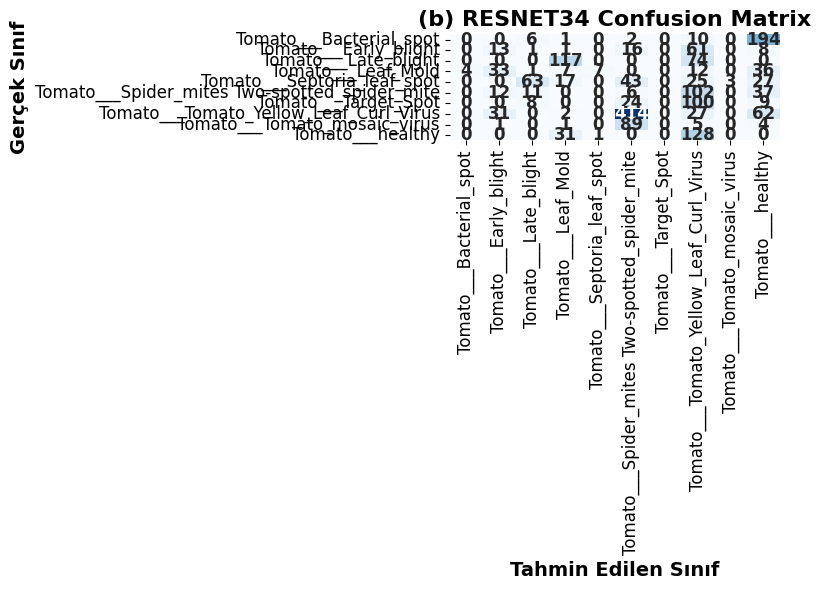

Missing keys: []
Unexpected keys: ['head.2.weight', 'head.2.bias']


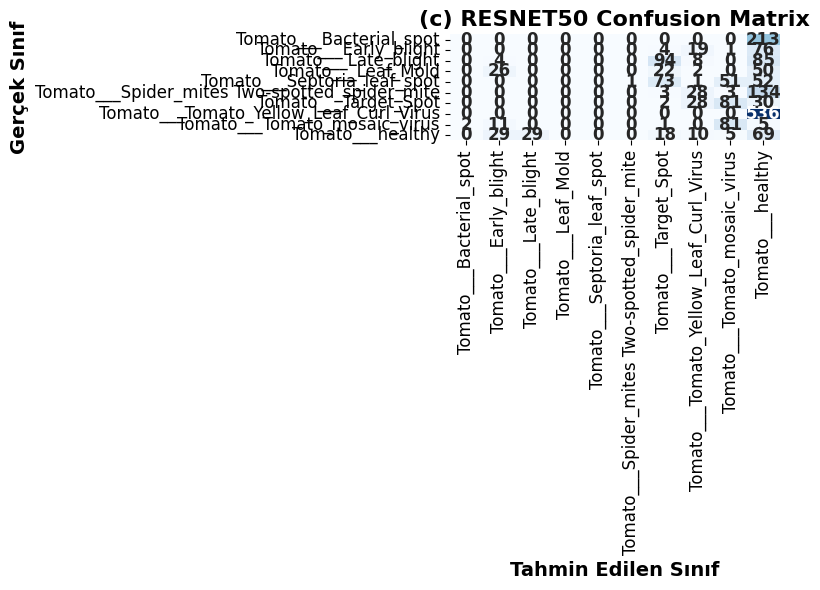

In [ ]:
# Model ve ağırlık dosyalarının bilgisi
model_infos = [
    ("resnet34", "/content/drive/MyDrive/resnet_early_stop/standart/resnet34.pth"),
    ("resnet34", "/content/drive/MyDrive/resnet_10_epoch/standart/resnet34.pth"),
    ("resnet50", "/content/drive/MyDrive/resnet_25_epoch/standart/resnet50.pth"),
]

for i, (model_name, weights_path) in enumerate(model_infos, 1):
    model = load_model(model_name, num_classes, weights_path)
    y_true, y_pred = get_preds_and_labels(model, val_loader)
    title = f"({chr(96+i)}) {model_name.upper()} Confusion Matrix"
    plot_confusion_matrix(y_true, y_pred, class_names, title)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-texgyre is already the newest version (20180621-3.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Yükleniyor: /content/drive/MyDrive/resnet_early_stop/standart/resnet34.pth


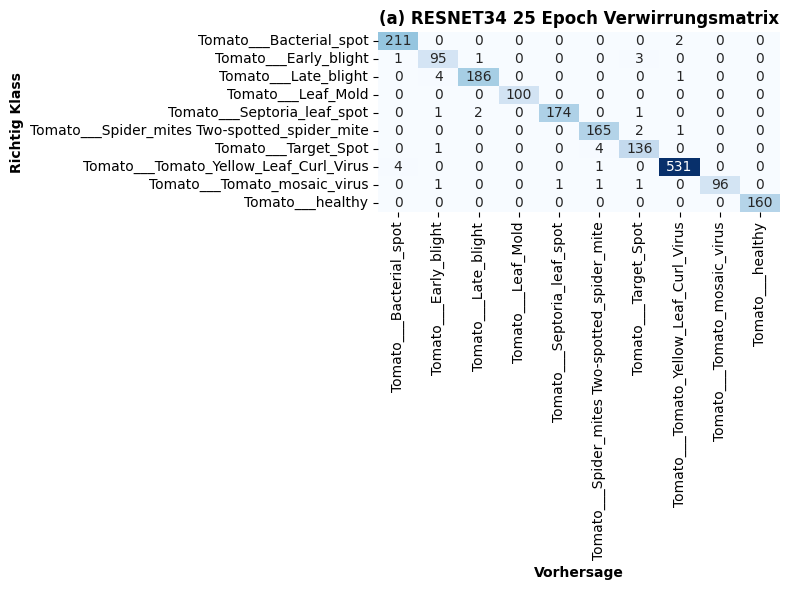

Yükleniyor: /content/drive/MyDrive/resnet_10_epoch/standart/resnet34.pth


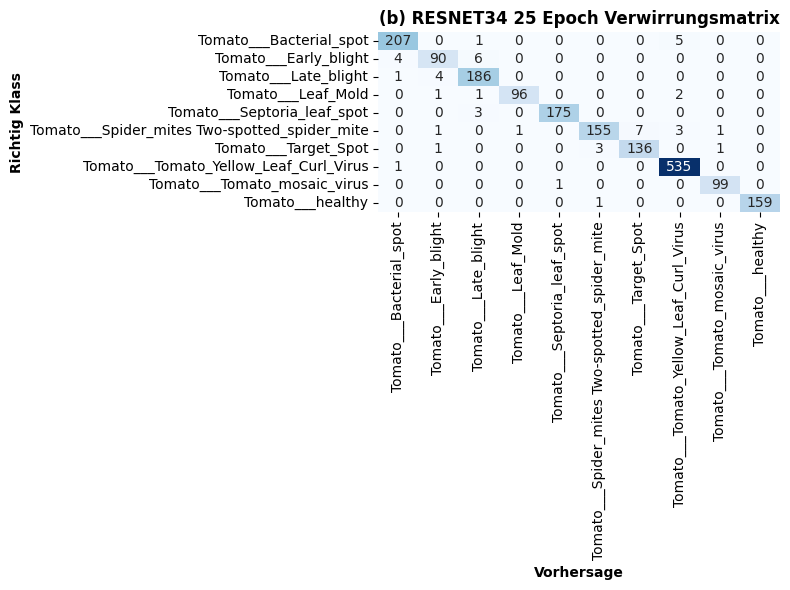

Yükleniyor: /content/drive/MyDrive/resnet_25_epoch/standart/resnet50.pth


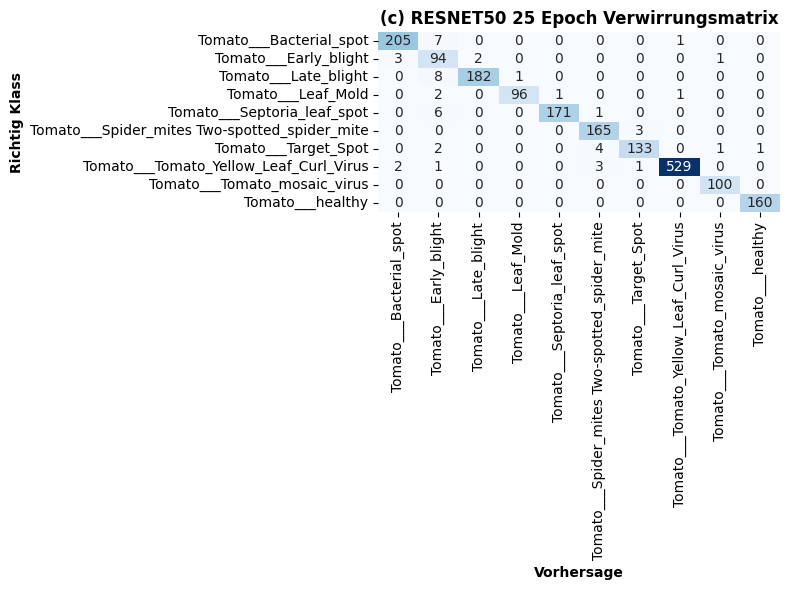

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- Font kurulumu ---
!apt-get install -y fonts-texgyre
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Times New Roman'
if not any('Times New Roman' in f.name for f in fm.fontManager.ttflist):
    plt.rcParams['font.family'] = 'TeX Gyre Termes'

# --- Data ---
val_dir  = "/content/ana_klasor/without_augmentation"
img_size = 224
batch_size = 32

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
class_names = val_dataset.classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model yükleme fonksiyonu ---
def build_my_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=False)
    in_features = model.num_features if hasattr(model, 'num_features') else model.head.in_features
    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(in_features, num_classes)
    )
    return model

# --- Kayıtlı modellerin yolları ---
model_infos = [
    ("resnet34", "/content/drive/MyDrive/resnet_early_stop/standart/resnet34.pth"),
    ("resnet34", "/content/drive/MyDrive/resnet_10_epoch/standart/resnet34.pth"),
    ("resnet50", "/content/drive/MyDrive/resnet_25_epoch/standart/resnet50.pth"),
]

def get_preds_and_labels(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={})
    ax.set_xlabel('Vorhersage', color='black', fontweight='bold')
    ax.set_ylabel('Richtig Klass', color='black', fontweight='bold')
    ax.set_title(title, color='black', fontweight='bold')
    plt.xticks(color='black')
    plt.yticks(color='black')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    plt.show()

# --- Her bir model için döngü ---
for i, (model_name, weights_path) in enumerate(model_infos, 1):
    print(f"Yükleniyor: {weights_path}")
    model = build_my_model(model_name, num_classes)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model = model.to(device)
    model.eval()
    y_true, y_pred = get_preds_and_labels(model, val_loader)
    title = f"({chr(96+i)}) {model_name.upper()} 25 Epoch Verwirrungsmatrix"
    plot_confusion_matrix(y_true, y_pred, class_names, title)

ara bölüm sonu asıl bölüm başı

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/Yeni WinRAR ZIP arşivi2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/ana_klasor")

ana_klasor_yolu = r"/content/ana_klasor"  # Burayı değiştir

toplam_dosya = 0
klasor_ozet = {}

# Kök klasörde gezinir
for kok, alt_klasorler, dosyalar in os.walk(ana_klasor_yolu):
    # Her klasördeki dosya sayısı
    dosya_sayisi = len([d for d in dosyalar if not d.startswith('.')])  # Gizli dosyalar hariç
    if dosya_sayisi > 0:
        klasor_ozet[kok] = dosya_sayisi
        toplam_dosya += dosya_sayisi

print(f"Toplam dosya sayısı: {toplam_dosya}\n")

print("Klasör bazında dosya sayıları:\n")
for klasor, sayi in klasor_ozet.items():
    print(f"{klasor} ---> {sayi} dosya")


Toplam dosya sayısı: 18835

Klasör bazında dosya sayıları:

/content/ana_klasor/augmentation/Tomato___Spider_mites Two-spotted_spider_mite ---> 1508 dosya
/content/ana_klasor/augmentation/Tomato___Tomato_mosaic_virus ---> 900 dosya
/content/ana_klasor/augmentation/Tomato___Target_Spot ---> 1263 dosya
/content/ana_klasor/augmentation/Tomato___healthy ---> 1431 dosya
/content/ana_klasor/augmentation/Tomato___Late_blight ---> 1718 dosya
/content/ana_klasor/augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus ---> 4821 dosya
/content/ana_klasor/augmentation/Tomato___Leaf_Mold ---> 900 dosya
/content/ana_klasor/augmentation/Tomato___Early_blight ---> 900 dosya
/content/ana_klasor/augmentation/Tomato___Septoria_leaf_spot ---> 1593 dosya
/content/ana_klasor/augmentation/Tomato___Bacterial_spot ---> 1914 dosya
/content/ana_klasor/without_augmentation/Tomato___Spider_mites Two-spotted_spider_mite ---> 168 dosya
/content/ana_klasor/without_augmentation/Tomato___Tomato_mosaic_virus ---> 100 dosya


resnet 18

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/25]  Train Loss: 1.8091  Val Loss: 0.6702  Time: 23.92s
Epoch [2/25]  Train Loss: 0.5198  Val Loss: 0.4311  Time: 22.44s
Epoch [3/25]  Train Loss: 0.3475  Val Loss: 0.2679  Time: 22.59s
Epoch [4/25]  Train Loss: 0.2568  Val Loss: 0.1899  Time: 22.84s
Epoch [5/25]  Train Loss: 0.2072  Val Loss: 0.2057  Time: 23.19s
Epoch [6/25]  Train Loss: 0.1700  Val Loss: 0.1383  Time: 23.64s
Epoch [7/25]  Train Loss: 0.1378  Val Loss: 0.1561  Time: 23.03s
Epoch [8/25]  Train Loss: 0.1252  Val Loss: 0.1815  Time: 22.94s
Epoch [9/25]  Train Loss: 0.1086  Val Loss: 0.1069  Time: 23.00s
Epoch [10/25] 

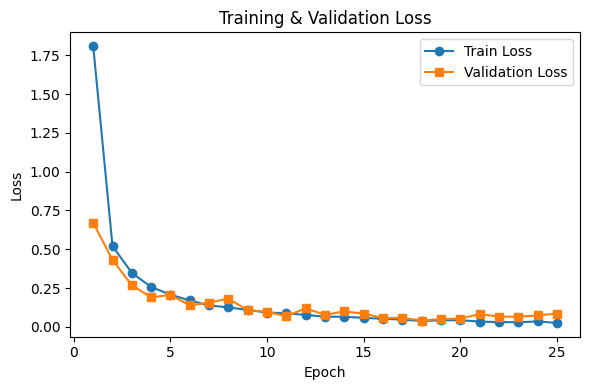


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9892,0.9684,0.9787,190.0
Tomato___Early_blight,0.9888,0.8980,0.9412,98.0
Tomato___Late_blight,0.9579,0.9903,0.9739,207.0
Tomato___Leaf_Mold,0.9725,0.9907,0.9815,107.0
Tomato___Septoria_leaf_spot,0.9941,0.9655,0.9796,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9274,0.9595,0.9432,173.0
Tomato___Target_Spot,0.9388,0.9583,0.9485,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9923,0.9885,0.9904,524.0
Tomato___Tomato_mosaic_virus,0.9895,0.9895,0.9895,95.0
Tomato___healthy,0.9871,1.0000,0.9935,153.0



✅ Genel Accuracy: 0.9759


<ipython-input-2-075ac5b20cf7>:158: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


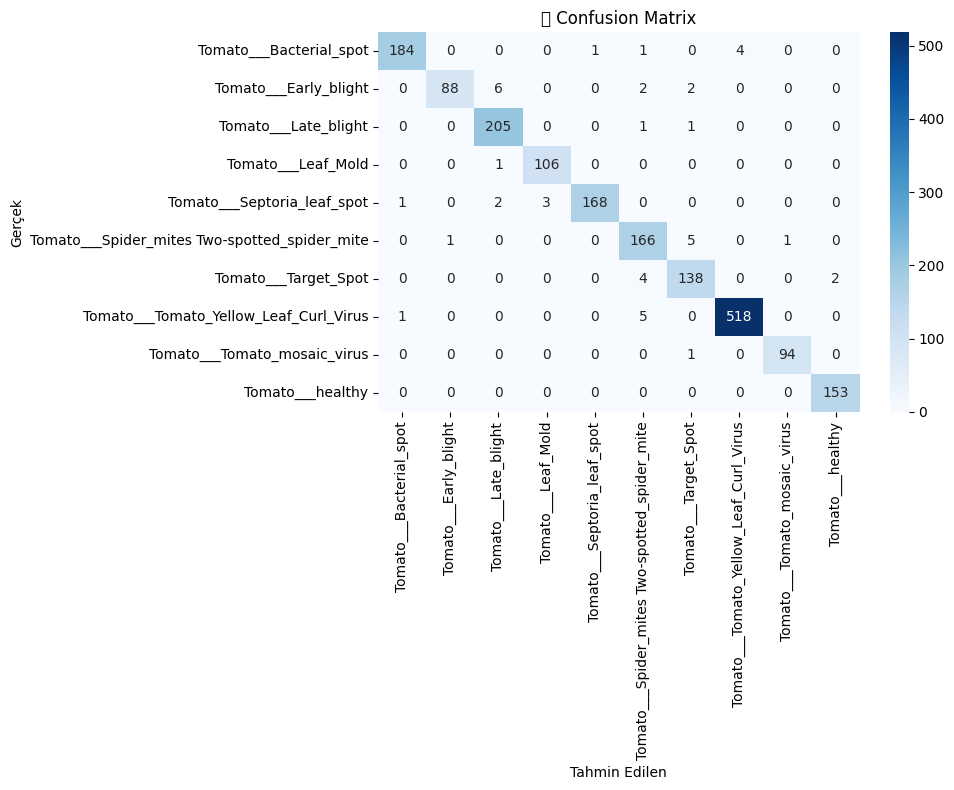

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model1 = timm.create_model('resnet18', pretrained=False)
in_features = model1.num_features if hasattr(model1, 'num_features') else model1.head.in_features
model1.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 25
train_losses = []
val_losses   = [] # Burası artık VALIDATION loss'larını tutacak

for epoch in range(1, epochs+1):
    # -- Train --
    model1.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model1.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader: # <<< Burayı val_loader olarak değiştirin
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader) # <<< Burayı len(val_loader) olarak değiştirin

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}" # Bu çıktı artık VALIDATION loss'unu gösterecek
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss) # Burası artık VALIDATION loss'larını tutacak

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
# Bu bölümün başlığı "Training & Validation Loss" olarak kalabilir veya "Training & Evaluation Loss" olarak değiştirilebilir,
# çünkü 'Val Loss' artık validasyon setinin performansını gösteriyor.
plt.figure(figsize=(6,4))
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Validation Loss') # Legend'ı "Validation Loss" olarak değiştirebilirsiniz
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss') # Başlık da aynı şekilde
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model1.state_dict(), "resnet18.pth")

# --- 6) Son test & rapor ---
model1.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Raporlama ve Confusion Matrix oluşturma kısmı aynı kalır,
# çünkü all_preds ve all_labels artık yeni test setinin sonuçlarını içerecek.
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

şimdi resnet 34

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/25]  Train Loss: 1.6594  Val Loss: 0.5631  Time: 36.71s
Epoch [2/25]  Train Loss: 0.4250  Val Loss: 0.3299  Time: 36.42s
Epoch [3/25]  Train Loss: 0.2940  Val Loss: 0.2537  Time: 36.26s
Epoch [4/25]  Train Loss: 0.2300  Val Loss: 0.1417  Time: 36.53s
Epoch [5/25]  Train Loss: 0.1934  Val Loss: 0.1997  Time: 36.38s
Epoch [6/25]  Train Loss: 0.1681  Val Loss: 0.1343  Time: 36.32s
Epoch [7/25]  Train Loss: 0.1343  Val Loss: 0.1213  Time: 36.40s
Epoch [8/25]  Train Loss: 0.1259  Val Loss: 0.0902  Time: 36.45s
Epoch [9/25]  Train Loss: 0.1063  Val Loss: 0.1019  Time: 36.34s
Epoch [10/25] 

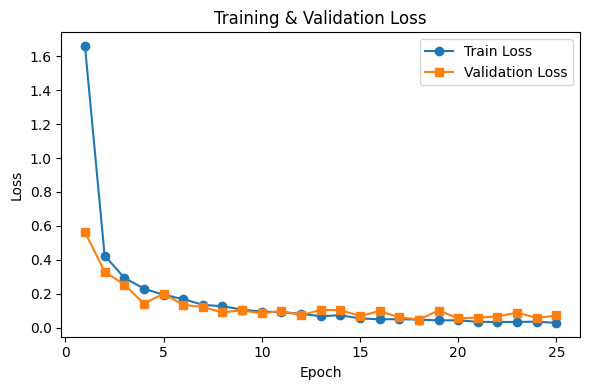


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9406,1.0000,0.9694,190.0
Tomato___Early_blight,0.9625,0.7857,0.8652,98.0
Tomato___Late_blight,0.9079,1.0000,0.9517,207.0
Tomato___Leaf_Mold,1.0000,0.9907,0.9953,107.0
Tomato___Septoria_leaf_spot,1.0000,0.9943,0.9971,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9818,0.9364,0.9586,173.0
Tomato___Target_Spot,0.9716,0.9514,0.9614,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9961,0.9866,0.9914,524.0
Tomato___Tomato_mosaic_virus,0.9896,1.0000,0.9948,95.0
Tomato___healthy,0.9871,1.0000,0.9935,153.0



✅ Genel Accuracy: 0.9743


<ipython-input-3-b1323f63b9f2>:158: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


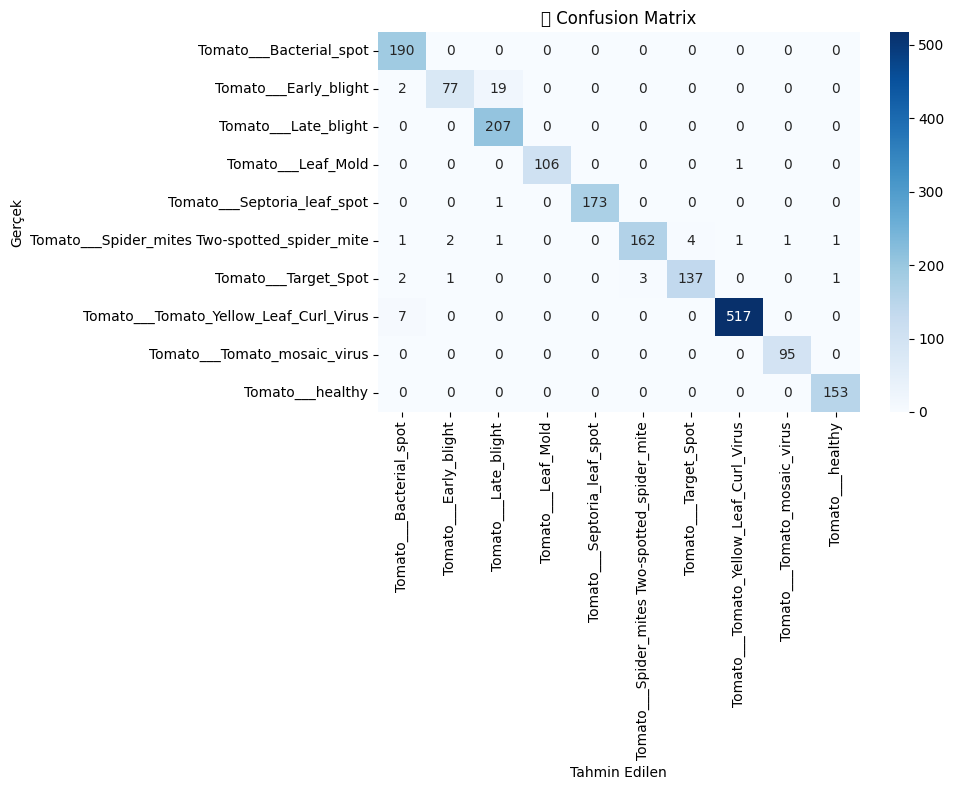

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model2 = timm.create_model('resnet34', pretrained=False)
in_features = model2.num_features if hasattr(model2, 'num_features') else model2.head.in_features
model2.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 25
train_losses = []
val_losses   = [] # Burası artık VALIDATION loss'larını tutacak

for epoch in range(1, epochs+1):
    # -- Train --
    model2.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader: # <<< Burayı val_loader olarak değiştirin
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader) # <<< Burayı len(val_loader) olarak değiştirin

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}" # Bu çıktı artık VALIDATION loss'unu gösterecek
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss) # Burası artık VALIDATION loss'larını tutacak

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
# Bu bölümün başlığı "Training & Validation Loss" olarak kalabilir veya "Training & Evaluation Loss" olarak değiştirilebilir,
# çünkü 'Val Loss' artık validasyon setinin performansını gösteriyor.
plt.figure(figsize=(6,4))
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Validation Loss') # Legend'ı "Validation Loss" olarak değiştirebilirsiniz
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss') # Başlık da aynı şekilde
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model2.state_dict(), "resnet34.pth")

# --- 6) Son test & rapor ---
model2.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Raporlama ve Confusion Matrix oluşturma kısmı aynı kalır,
# çünkü all_preds ve all_labels artık yeni test setinin sonuçlarını içerecek.
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

şimdi de resnet50

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/25]  Train Loss: 0.9110  Val Loss: 0.3767  Time: 74.79s
Epoch [2/25]  Train Loss: 0.3597  Val Loss: 0.2397  Time: 74.36s
Epoch [3/25]  Train Loss: 0.2592  Val Loss: 0.1812  Time: 74.34s
Epoch [4/25]  Train Loss: 0.1973  Val Loss: 0.1481  Time: 74.48s
Epoch [5/25]  Train Loss: 0.1691  Val Loss: 0.1227  Time: 74.39s
Epoch [6/25]  Train Loss: 0.1343  Val Loss: 0.1285  Time: 74.38s
Epoch [7/25]  Train Loss: 0.1139  Val Loss: 0.1207  Time: 74.48s
Epoch [8/25]  Train Loss: 0.0913  Val Loss: 0.1016  Time: 74.42s
Epoch [9/25]  Train Loss: 0.0853  Val Loss: 0.0907  Time: 74.42s
Epoch [10/25] 

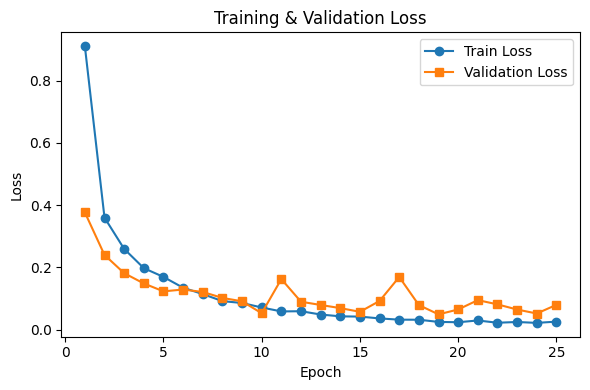


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9946,0.9737,0.9840,190.0
Tomato___Early_blight,0.8509,0.9898,0.9151,98.0
Tomato___Late_blight,0.9902,0.9758,0.9830,207.0
Tomato___Leaf_Mold,1.0000,0.9813,0.9906,107.0
Tomato___Septoria_leaf_spot,0.9824,0.9598,0.9709,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9543,0.9653,0.9598,173.0
Tomato___Target_Spot,0.9710,0.9306,0.9504,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9981,0.9962,0.9971,524.0
Tomato___Tomato_mosaic_virus,1.0000,1.0000,1.0000,95.0
Tomato___healthy,0.9806,0.9935,0.9870,153.0



✅ Genel Accuracy: 0.9791


<ipython-input-4-dc09a51b256e>:158: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


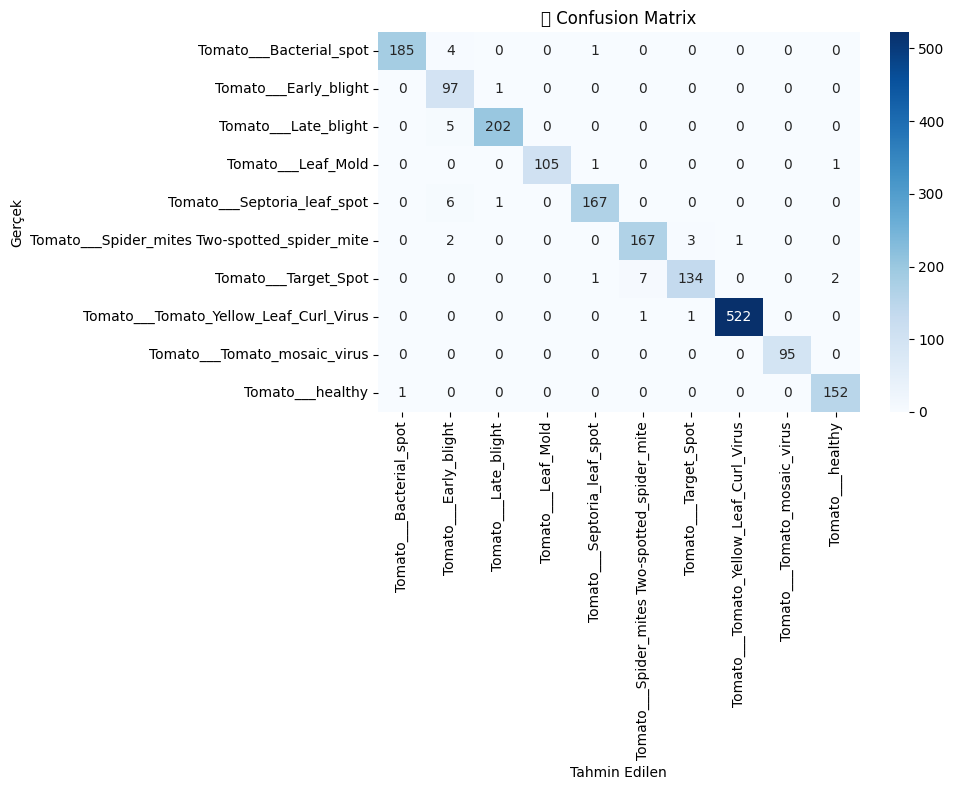

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model3 = timm.create_model('resnet50', pretrained=False)
in_features = model3.num_features if hasattr(model3, 'num_features') else model3.head.in_features
model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 25
train_losses = []
val_losses   = [] # Burası artık VALIDATION loss'larını tutacak

for epoch in range(1, epochs+1):
    # -- Train --
    model3.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model3.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader: # <<< Burayı val_loader olarak değiştirin
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader) # <<< Burayı len(val_loader) olarak değiştirin

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}" # Bu çıktı artık VALIDATION loss'unu gösterecek
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss) # Burası artık VALIDATION loss'larını tutacak

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
# Bu bölümün başlığı "Training & Validation Loss" olarak kalabilir veya "Training & Evaluation Loss" olarak değiştirilebilir,
# çünkü 'Val Loss' artık validasyon setinin performansını gösteriyor.
plt.figure(figsize=(6,4))
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Validation Loss') # Legend'ı "Validation Loss" olarak değiştirebilirsiniz
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss') # Başlık da aynı şekilde
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model3.state_dict(), "resnet50.pth")

# --- 6) Son test & rapor ---
model3.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Raporlama ve Confusion Matrix oluşturma kısmı aynı kalır,
# çünkü all_preds ve all_labels artık yeni test setinin sonuçlarını içerecek.
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

📊 Evaluating ResNet18...
📊 Evaluating ResNet34...
📊 Evaluating ResNet50...

📈 Karşılaştırmalı Sınıflandırma Performansı:


,Model,Precision,Recall,F1-Score,Accuracy
0,ResNet18,0.9763,0.9759,0.9759,0.9759
1,ResNet34,0.9752,0.9743,0.9739,0.9743
2,ResNet50,0.9803,0.9791,0.9793,0.9791


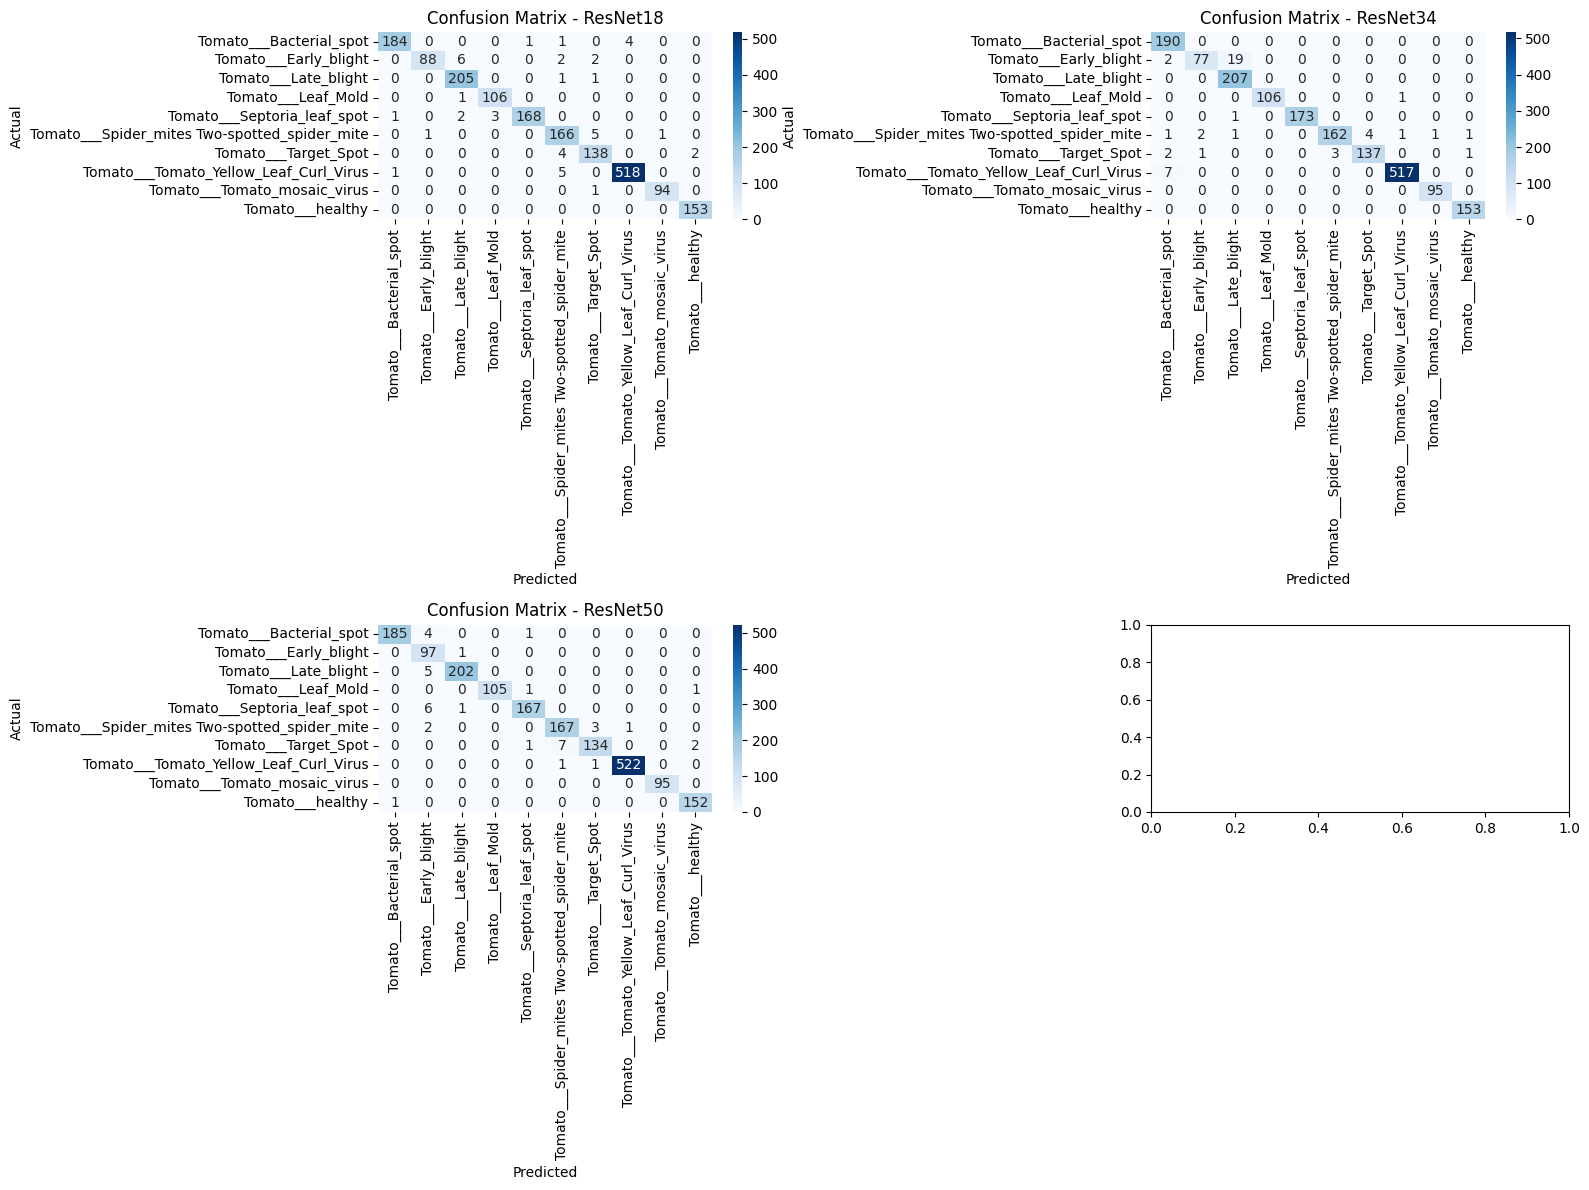

In [ ]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        output_dict=True
    )

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    return report, cm

    # Değerlendirmeyi yapacağımız modeller
models = {
    "ResNet18": model1,
    "ResNet34": model2,
    "ResNet50": model3
}

reports = {}
conf_matrices = {}

for name, model in models.items():
    print(f"📊 Evaluating {name}...")
    report, cm = evaluate_model(model, test_loader, class_names, device)
    reports[name] = report
    conf_matrices[name] = cm

    # Her model için weighted avg (veya macro avg) precision, recall, f1-score değerlerini toplayalım
summary_data = []

for name, report in reports.items():
    row = {
        "Model": name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Accuracy": report["accuracy"]
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("\n📈 Karşılaştırmalı Sınıflandırma Performansı:")
display(summary_df)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

burada da semantic dictionary metodunu test ediyorum, 10 farklı sınıfın her biri için anlamlı channel'ları tespit ediyorum.

In [ ]:
models_path_list = ["/content/resnet18.pth", "/content/resnet34.pth", "/content/resnet50.pth"]
models_name_list = ["resnet18", "resnet34", "resnet50"]
important_channels_combined = []

for models_name in models_name_list:
  for models_path in models_path_list:
    if models_name in models_path:

      #semantic veriyi liste olarak kaydettiğim, yani 50 channelın tamamını classına bakmaksızın kaydediyoruz
      # Modeli doğru sınıf sayısıyla başlat
      model = timm.create_model(models_name, pretrained=False, num_classes=10)

      # Ağırlıkları yüklemeden önce state_dict'i oku
      state_dict = torch.load(models_path, map_location=torch.device("cpu"))

      # ❌ FC katmanı ağırlıklarını çıkar
      state_dict = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}

      # Geri kalan ağırlıkları yükle (strict=False gerekmez artık)
      model.load_state_dict(state_dict, strict=False)
      model.eval()

      # 🧠 GAP öncesi son conv katmanını bul
      if models_name == "resnet18" or models_name == "resnet34":
        target_layer = model.layer4[-1].conv2
      else:
        target_layer = model.layer4[-1].conv3
      feature_maps = []

      def forward_hook(module, input, output):
          feature_maps.append(output.detach())

      hook_handle = target_layer.register_forward_hook(forward_hook)

      # 📂 Validation verisini yükle
      data_dir = "/content/without_augmentation"
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
      dataset = datasets.ImageFolder(data_dir, transform=transform)
      dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
      class_names = dataset.classes

      # 🔍 Her örnek için gerçek etiketli feature map katkısını al
      semantic_dict = {}              # {class_idx: [channel_contributions]}
      important_channels_set = set() # ❗ Tüm sınıfların önemli kanallarını saklayan set

      for img_tensor, label in dataloader:
          feature_maps.clear()
          output = model(img_tensor)

          true_class = label.item()  # gerçek sınıf etiketi
          weights = model.fc.weight[true_class]  # sınıfa özel FC ağırlıkları

          fmap = feature_maps[0]            # (1, C, H, W)
          fmap = fmap.squeeze(0)            # (C, H, W)
          pooled = torch.mean(fmap.view(fmap.shape[0], -1), dim=1)  # GAP: (C,)

          contribution = pooled * weights   # kanal katkı değeri (C,)

          if true_class not in semantic_dict:
              semantic_dict[true_class] = []

          semantic_dict[true_class].append(contribution.detach().cpu().numpy())

      # 📊 Her sınıf için ortalama katkı vektörünü yazdır + önemli kanalları topla
      for cls, contribs in semantic_dict.items():
          contribs = np.stack(contribs)
          mean_contrib = np.mean(contribs, axis=0)
          top_channels = np.argsort(-mean_contrib)[:5]  # en büyük 5 kanal

          #print(f"\n🔸 Sınıf: {class_names[cls]} (Index {cls}) için en anlamlı 5 kanal:")
          for idx in top_channels:
          #    print(f"   Kanal {idx}: katkı = {mean_contrib[idx]:.4f}")
              important_channels_set.add(idx)  # ✅ Tekrarsız olarak ekle

      # ✅ Tüm önemli kanalları topla ve sırala
      important_channels = sorted(list(important_channels_set))
      print(f"\n📦 Tüm sınıflarda öne çıkan toplam {len(important_channels)} kanal:")
      print(important_channels)
      important_channels_combined.append(important_channels)

  print(important_channels_combined)


📦 Tüm sınıflarda öne çıkan toplam 42 kanal:
[np.int64(8), np.int64(15), np.int64(33), np.int64(35), np.int64(47), np.int64(55), np.int64(63), np.int64(66), np.int64(68), np.int64(76), np.int64(94), np.int64(110), np.int64(116), np.int64(118), np.int64(141), np.int64(159), np.int64(172), np.int64(193), np.int64(207), np.int64(230), np.int64(241), np.int64(250), np.int64(252), np.int64(257), np.int64(277), np.int64(289), np.int64(304), np.int64(313), np.int64(323), np.int64(354), np.int64(355), np.int64(370), np.int64(372), np.int64(384), np.int64(388), np.int64(403), np.int64(414), np.int64(416), np.int64(459), np.int64(473), np.int64(486), np.int64(495)]
[[np.int64(8), np.int64(15), np.int64(33), np.int64(35), np.int64(47), np.int64(55), np.int64(63), np.int64(66), np.int64(68), np.int64(76), np.int64(94), np.int64(110), np.int64(116), np.int64(118), np.int64(141), np.int64(159), np.int64(172), np.int64(193), np.int64(207), np.int64(230), np.int64(241), np.int64(250), np.int64(252), n